## Single delayed inverted pendulum example

The parameters: tau=sqrt(2)/4 and b=1.5 (fixed). Parameter 'a' is varied.

In [18]:
using CairoMakie
using LinearAlgebra
include("invpend_1delay.jl") #RHS of single delay inverted pendulum example
include("inpend1tau.jl") #Delay function for inverted pendulum example
include("f_deriv.jl") #used to find state and/or parameter derivatives
include("jacobian_new.jl") #Jacobian function
include("newton_new.jl") #Newton function
include("F_eq.jl") #Initialisates a function to find equilibria 
include("track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("stab_func.jl") #finds stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)

stab_func (generic function with 1 method)

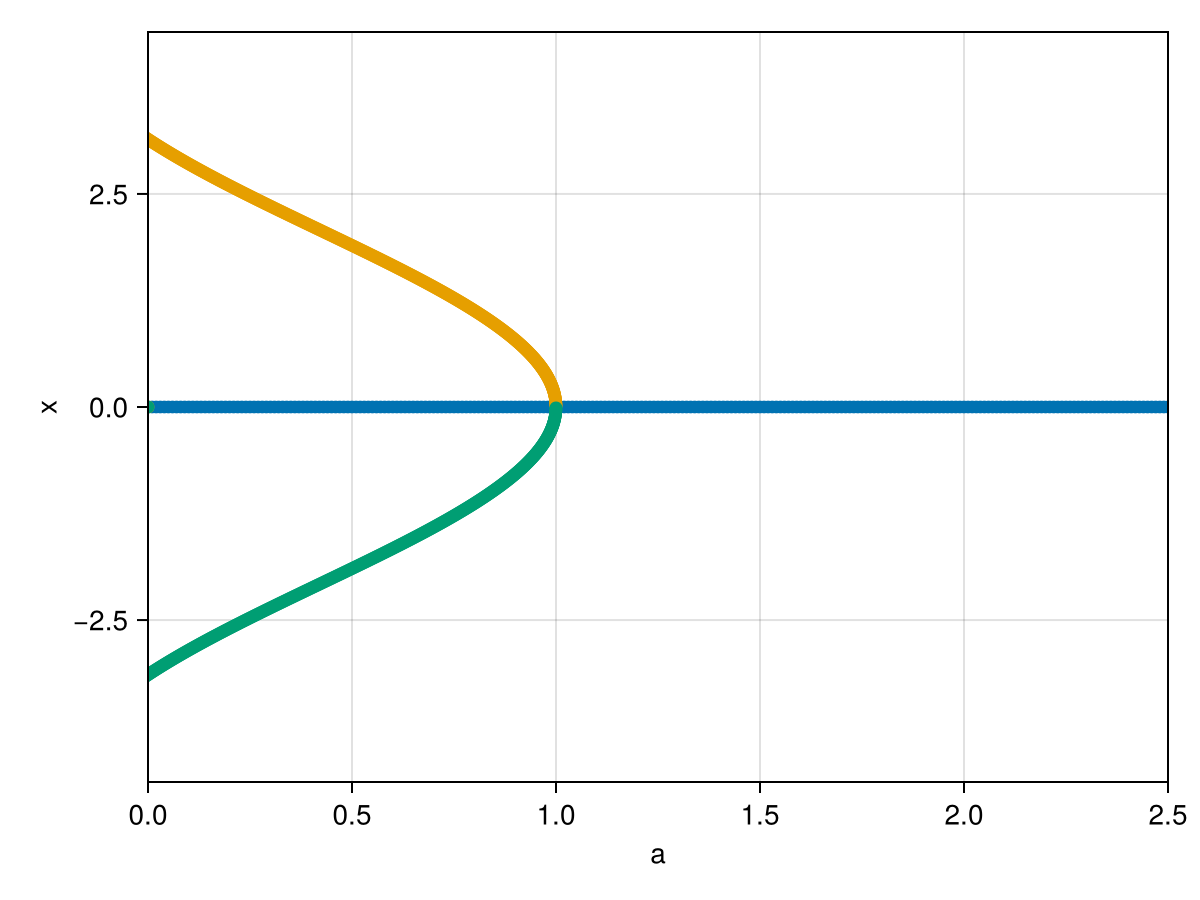

In [19]:
a=0.0 #parameter a - starts at 0 as this is the parameter we're varying over
b=1.5 #parameter b - fixed 
tau=sqrt(2)/4 #delay τ
nd=1 #number of delays (single delay so nd=1)

#Now we looking at finding the equilibria branches
y01,f_equ=F_eq(invpend_1delay,[0.0,0],[a,b,tau],nd,par_indx=1)#nd=1,pars_indx=1 as parameter a (the parameter we're varying) is the first parameter
#The above ouputs the initial guess for x,v and parameter 'a' and the equilibrium function

ylist1,ytan1=track_curve_new(f_equ,y01,[0.0,0,1],nmax=1000) #initial tangent changes a (initial tangent=[0.0,0,1])
ylist2,ytan2=track_curve_new(f_equ,y01,[1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in postive x direction
ylist3,ytan3=track_curve_new(f_equ,y01,[-1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in negative x direction


fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a",ylabel="x")
scatter!(ax1,[u[3] for u in ylist1],[u[1] for u in ylist1])
scatter!(ax1,[u[3] for u in ylist2],[u[1] for u in ylist2])
scatter!(ax1,[u[3] for u in ylist3],[u[1] for u in ylist3])
xlims!(ax1,[0.0,2.5])
fig1

# Stability

In [20]:
#Check that the outputs are equilibria 
u0ex1=ylist2[5][1:2] #equilibrium point values for x value
pex1=ylist2[5][3]# (varied) parameter - in this case a - that allows for u0ex1 to be an equilibrium point
u0vec1=[ylist2[5][1:2] for _ in 1:2]
invpend_1delay(u0vec1,[ylist2[5][3],b,tau]) #check this outputs 0's (it should as u0ex1 is an equilibrium point)

2-element Vector{Float64}:
 -2.692645223154387e-28
  4.0389678347315804e-28

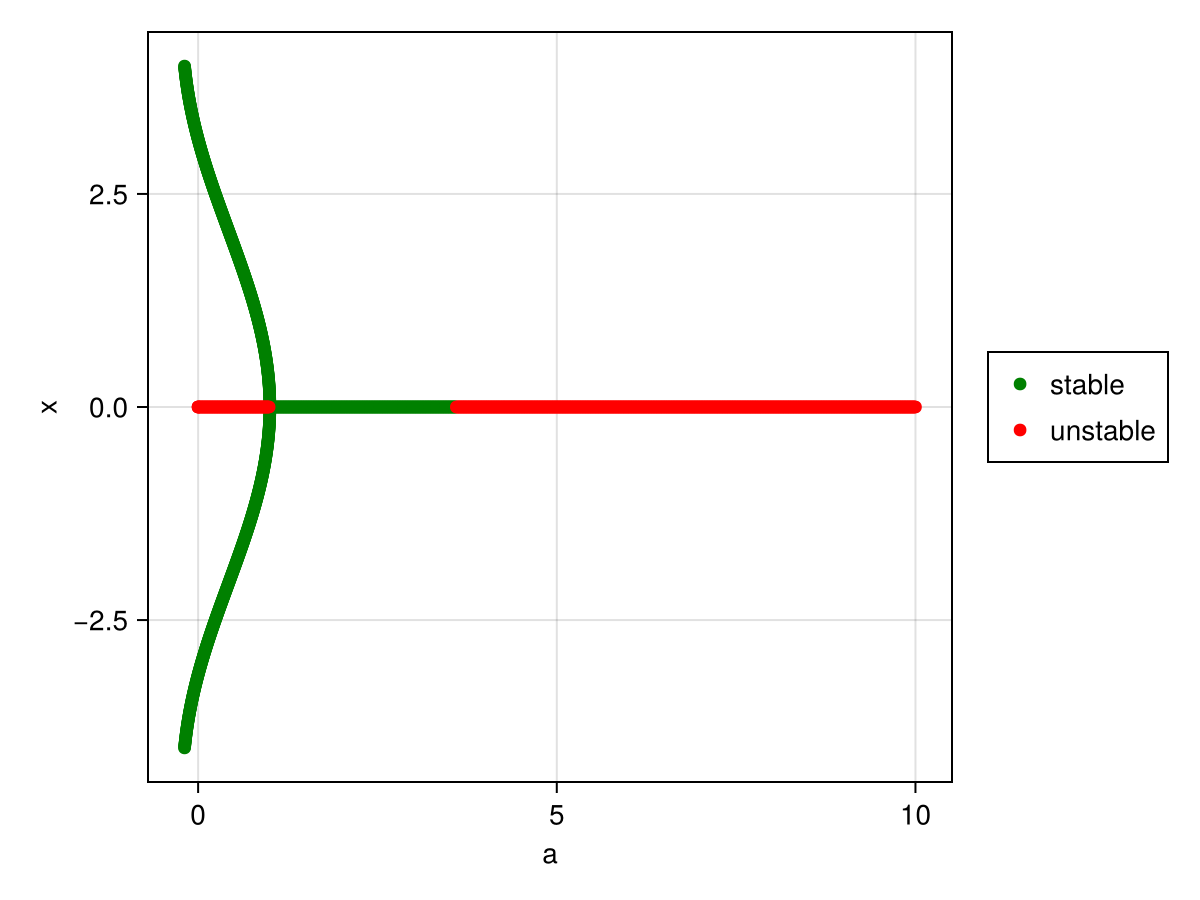

In [21]:
#Now we look at stability of the steady-state branches
xmat1=hcat([u[1] for u in ylist1],[u[2] for u in ylist1])
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)]
xmat2=hcat([u[1] for u in ylist2],[u[2] for u in ylist2])
xlist2=[xmat2[i,:] for i in 1:size(xmat2,1)]
xmat3=hcat([u[1] for u in ylist3],[u[2] for u in ylist3])
xlist3=[xmat3[i,:] for i in 1:size(xmat3,1)]

plist1=[u[3] for u in ylist1]
plist2=[u[3] for u in ylist2]
plist3=[u[3] for u in ylist3]

xlist=vcat(xlist1,xlist2,xlist3)
plist=vcat(plist1,plist2,plist3)

neq=length(plist) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 1:neq
    stab[i]=stab_func(invpend_1delay,inpend1tau,xlist[i],[plist[i]],[a,b,tau],[1],nd,doprint=0)
end 


stable=(stab.==1.0)
unstable=(stab.==0.0)

fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="a",ylabel="x")
scatter!(ax2,plist[stable],[u[1] for u in xlist[stable]],label="stable",color="green")
scatter!(ax2,plist[unstable],[u[1] for u in xlist[unstable]],label="unstable",color="red")
Legend(fig2[1,2], ax2, merge=true)
fig2

# Hopf Bifurcation

In [22]:
stab_indx=findfirst(isequal(1.0),stab)#finds where stability changes first time
unstab2_indx=findfirst(isequal(0.0),stab[101:end]) # finds where stability changes again 
hopf_indx=stab_indx+unstab2_indx #index of where hopf bifurcation is
plist[hopf_indx] #parameter guess for hopf bifurcation

3.609999999999967

In [23]:
include("create_hopffunc.jl")
yh01,fhopf=create_hopffunc(invpend_1delay,inpend1tau,[a,b,tau],xlist[hopf_indx],[plist[hopf_indx]],[1],nd)
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01)
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The a value for hopf bifurcation: $a_hopf")
println("The ω value for hopf bifurcation: $om_hopf") #1.8910.. which is about 0.6π

The initial guess for Hopf info: [0.0, 0.0, 0.0010556818010089145, 0.8841119901586795, -0.46727387514560875, 0.0, 1.8920541561835698, 3.609999999999967]
The true information for the Hopf bifurcation: [0.0, 0.0, 0.0002306989626506165, 0.88400742918404, -0.467472589145734, 0.00043626001101129463, 1.8910358590211405, 3.5908064152889505]
converged?: true
The a value for hopf bifurcation: 3.5908064152889505
The ω value for hopf bifurcation: 1.8910358590211405


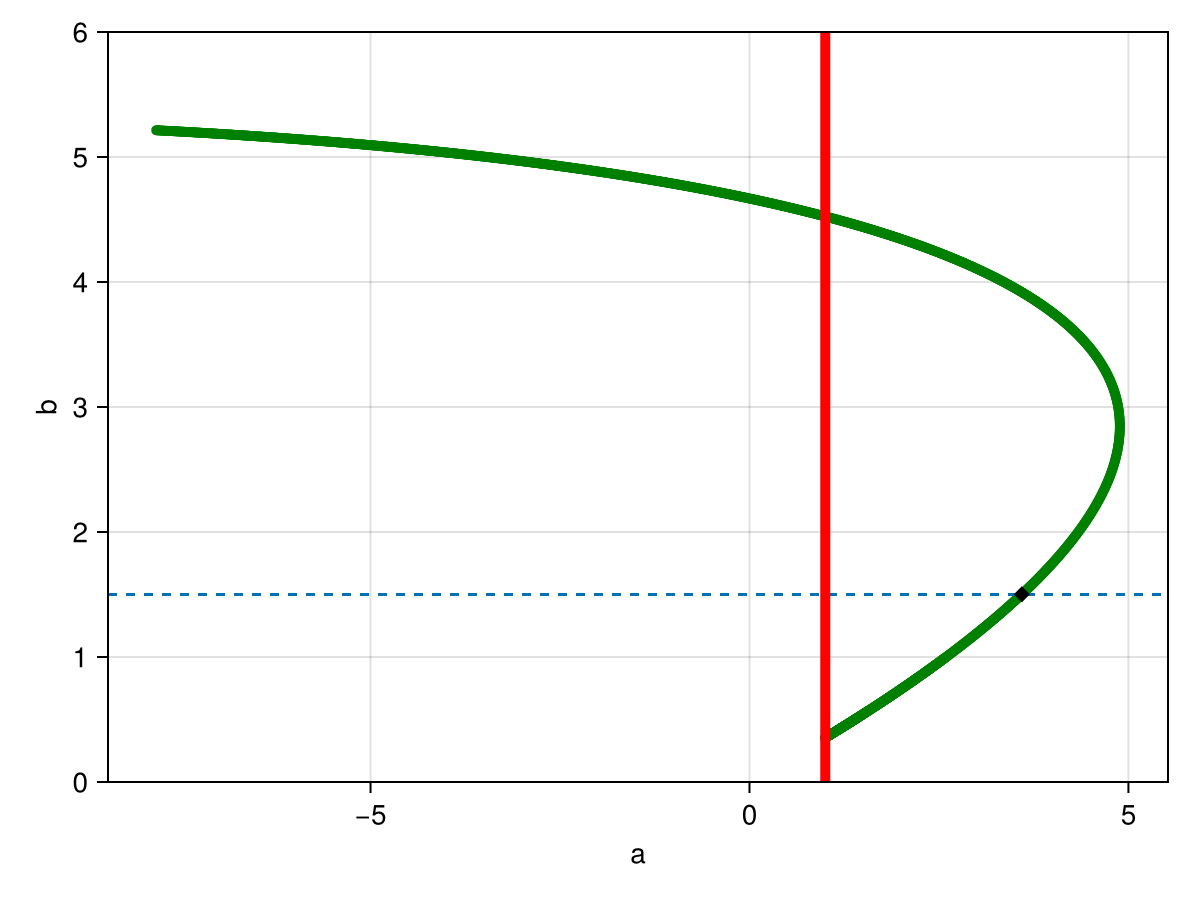

In [24]:
yheq01,fhopfeq1=create_hopffunc(invpend_1delay,inpend1tau,[a_hopf,0,tau],[0.0,0],[a_hopf,0],[1,2],nd)
yheqlist1,heqtan1=track_curve_new(fhopfeq1,yheq01,[0.0,0,0,0,0,0,0,-1,-1],nmax=2000)

#Below marks the Hopf bifurcation for fixed b=1.5
a_vals=[u[end-1] for u in yheqlist1]
b_vals=[u[end] for u in yheqlist1]
b1_5indx=argmin(abs.([u[end] for u in yheqlist1].-1.5))

a1=a_vals[b1_5indx]
b1=b_vals[b1_5indx]

#Plot of continuation/tracking in (a,b) plane
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a",ylabel="b")
scatter!(ax4,[u[end-1] for u in yheqlist1[2:end]],[u[end] for u in yheqlist1[2:end]],color="green",markersize=:7)
hlines!(ax4,1.5,linestyle=:dash)
scatter!(ax4,a1,b1,marker=:diamond,color=:black)
vlines!(ax4,1,linestyle=:solid, linewidth=:5,color=:red)
ylims!(ax4,[0,6])
fig4